# Example of End-To-End Machine Learning Problem

## California Housing Price Prediction using Random Tree Regressors

Want to buy a new house in California? Deal! , Let's create a model to predict the price of your new house ,given your desired number of meters, proximity to the beach and your income.

We will use the California Housing dataset from 1970's to build a Random Tree Regressor in order to predict the Median House Value .

We will go through:

1. Data Exploration
2. Data Visualization
3. Analyzing problems: Scales, Skewness, Relevance, Missing Values
3. Data Splitting, train and test set
4. Stratified Sampling
5. Correlation
6. Pipeline Building: Data Cleaning, Log Transformations, Cluster Similarities , One Hot Encoding and Standarization
7. Model Creation : Random Tree Regressor
9. Hyperparameter Tuning using Randomized Search Cross Validation
9. Final model
10. Prediction with test set
11. Confidence Interval for our error estimator : Hypothesis Testing for Error Generalization, CI_95%


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import urllib.request
import seaborn as sns
from pathlib import Path
import warnings
import sklearn
sklearn.set_config(display='diagram')

First of all we create a function to retrieve our csv file by making a request to a repository, we check that the file exists, if not we create a folder to store the data.

In [3]:
housing_data = pd.read_csv('datasets/housing/housing.csv')

## Exploratory data Analysis

In [4]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can see that total_rooms have NAN values, we will take care of them later on

In [6]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


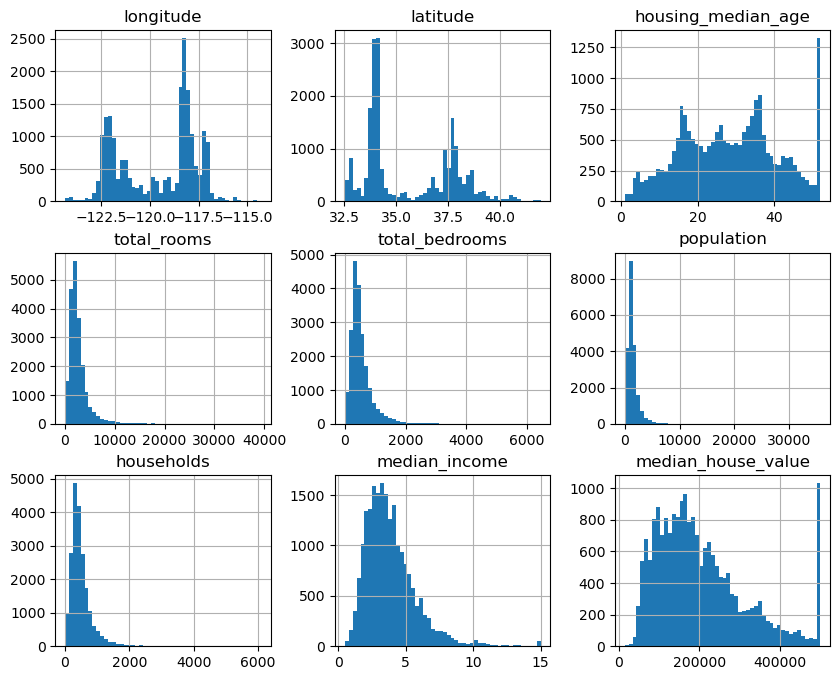

In [7]:
housing_data.hist(bins = 50, figsize=(10,8))
plt.show()

Various things to notice in this plot:

    1. The scales in the plot, for example the median income is expressed in 10.000 $ 
    2. median_house_values have some instances greater that 500.000 ,should we keep and properly scale them or drop them?
    3. Some distributions are right skewed so we will apply a standarization

## Creating a simple random test_set

We create a test set at this stage to avoid *'data snooping bias'* (bias arised from the fact that observating the test set might give us some preference on model selection) , but we'll see that simple random sampling is not representative for the population

In [8]:
from sklearn.model_selection import train_test_split 

train_set, test_set = train_test_split(housing_data, test_size= 0.2, random_state = 42)

In [9]:
print(f'Train Set = {train_set.shape} \nTest set = {test_set.shape}')

Train Set = (16512, 10) 
Test set = (4128, 10)


## Stratified Sampling

In order to handle the *sampling bias* (bias arised due to the lack of representative sampling) for the median income (an important feature to predict median house value) we make a stratified sampling, trying to create homogeneous groups of data that are representative, we can see that the proportions of sample median income are identical to the population median income, meaning that our test_set is representative for the whole population and then less prone to bias

In [10]:
#Create median income categories
housing_data['income_cat'] = pd.cut(housing_data['median_income'],
                                   bins = [0, 1.5, 3.0, 4.5, 6., np.inf],
                                   labels = [1,2,3,4,5])

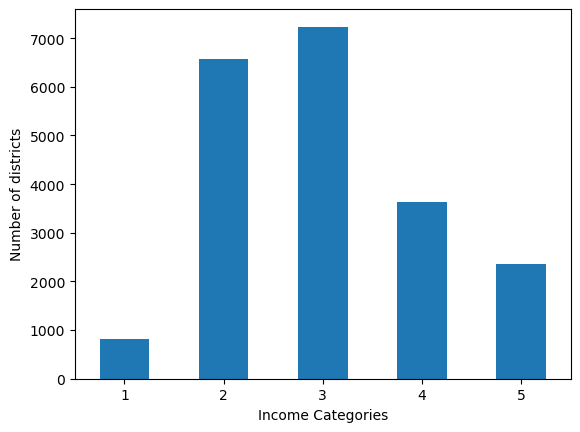

In [11]:
#Plot the categories
housing_data['income_cat'].value_counts().sort_index().plot.bar(rot = 0, grid = False)
plt.xlabel('Income Categories')
plt.ylabel('Number of districts')
plt.show()

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_train_set , strat_test_set = train_test_split(housing_data, test_size=0.2, stratify=housing_data["income_cat"], random_state = 42)

In [13]:
print(f'Train Set = {strat_train_set.shape} \nTest set = {strat_test_set.shape}')

Train Set = (16512, 11) 
Test set = (4128, 11)


In [14]:
#Drop the income_cat to reverse the data set
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Exploring The Data Set

We start by making a copy of the stratified train set, we set aside our test_set

In [15]:
copy_housing_data = strat_train_set.copy()

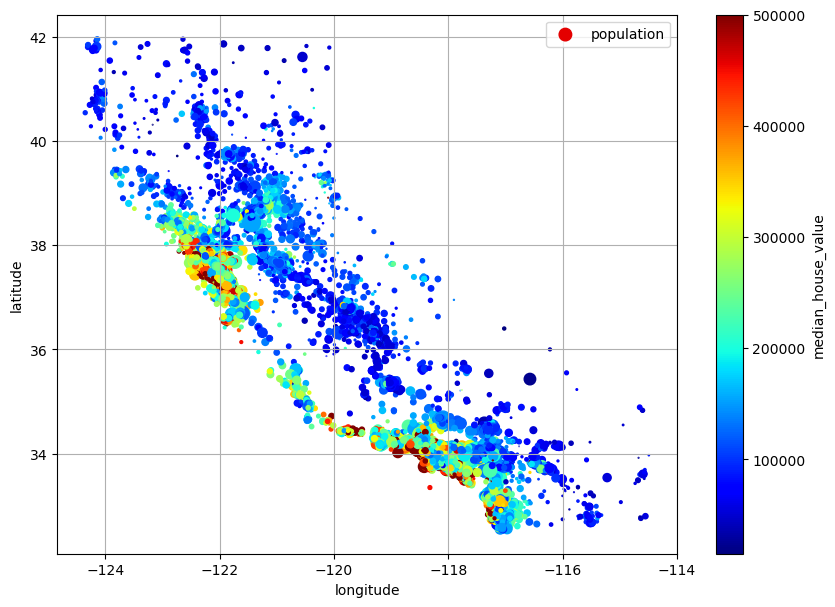

In [16]:
copy_housing_data.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True,
                      s =copy_housing_data["population"] / 100, label = "population",
                      c = "median_house_value", cmap = "jet", colorbar = True, 
                      legend = True, sharex = False, figsize = (10,7))
plt.show()

This plot let us gain some interesting insights, the distance to the beach and the population density play a big role on the median home value

## Correlation Matrix

In other to dive deeper on the data set we may want to look at the different correlations in the data set to find more interesting patterns

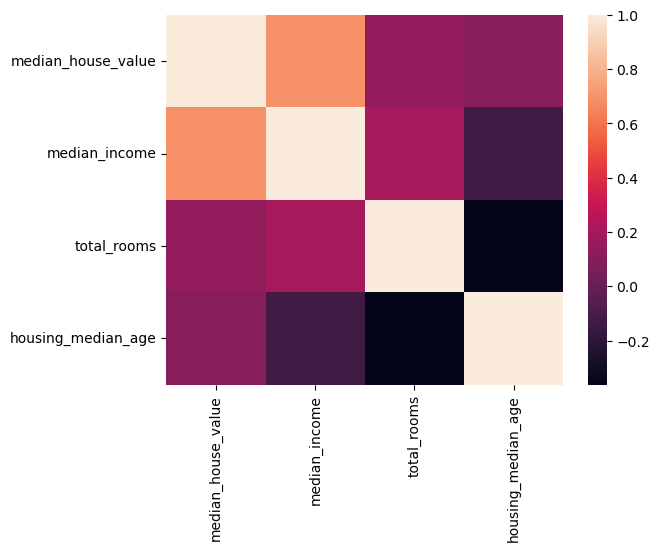

In [17]:
atributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
corr_matrix = copy_housing_data[atributes].corr()

sns.heatmap(corr_matrix)
plt.show()

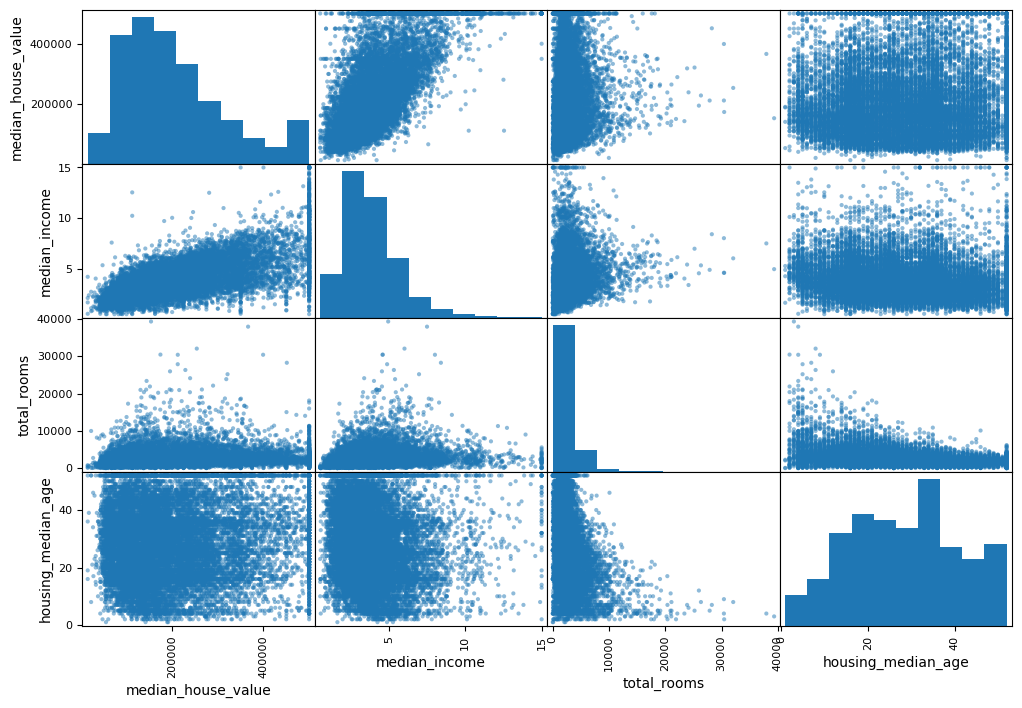

In [34]:
from pandas.plotting import scatter_matrix

scatter_matrix(copy_housing_data[atributes], figsize = (12, 8))
plt.show()

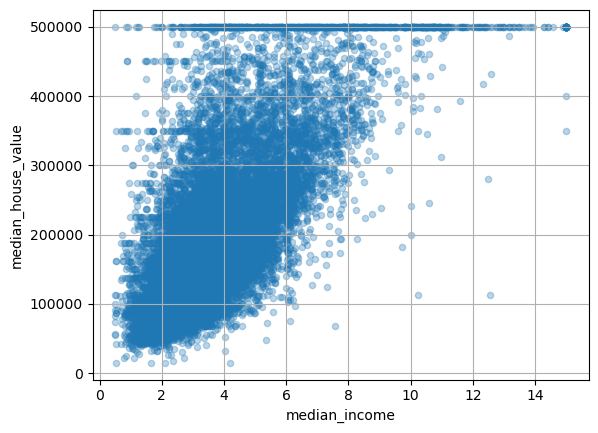

In [19]:
copy_housing_data.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.3, grid = True)
plt.show()

Median income and Median house value are strongly positive correlated, this are the features which we are going to work with

But the problem are these straight line patterns around 500.000 , 450.000 , 350.000 , we will remove them to preven the machine learning algorithm learn this data quirks

## Preparing data for Machine Learning Model

In [20]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

The following transformations and data cleaning will be applied:
    
1. Replace Numerical Missing Values imputing the median, for the categorical missing values impute the most frequent
2. One-Hot-encode the categorical feature (Ocean_proximity)
3. Create new Ratio Features
4. Compute Cluster Similarity , as a new feature for (Latitude , Longitude) 
5. Features with a long heavy tail (right skewed distributions) , apply a log transformation to make it bell shaped
6. Standarize data

In [21]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1., random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight= sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_features_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    
        

### Pipeline

In [22]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer


def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, features_name_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, validate=False),
        StandardScaler()
    )
    
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, validate=False),
    StandardScaler()
)
cluster_simil = ClusterSimilarity(n_clusters = 10, gamma = 1., random_state= 42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder()

)

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
],remainder = default_num_pipeline
)

In [23]:
housing_prepared = preprocessing.fit_transform(housing)

## Machine Learning Model Selection

As we are targeting a continous variable (median_house_value) we will evaluate our model using a Random Forest Regresor and evaluated with RMSE, validating with K-Fold Cross Validation

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = make_pipeline(preprocessing,RandomForestRegressor(random_state = 42))

forest_rsmes = -cross_val_score(forest_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=10)

In [25]:
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state = 42))
])

Next We'll Tune our hyperparameters using RandomizedSearchCV

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_range = {'preprocessing__geo__n_clusters': randint(low=3, high=20),
              'random_forest__max_features': randint(low = 2 , high = 20)}

random_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_range, n_iter= 10, cv = 3,
    scoring = 'neg_root_mean_squared_error', random_state = 42

)

random_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(func=<function...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x765365cedd50>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7653983fc190>},
                   random_state=42, scoring='neg_root_mean_squared_error')

### Final Model

In [27]:
final_model = random_search.best_estimator_

### Test the model

In [29]:
from sklearn.metrics import mean_squared_error

X_test = strat_test_set.drop("median_house_value", axis = 1)
Y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(Y_test, final_predictions, squared = False)
print(final_rmse)

43734.26165199388


/home/psykoss/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Confidence Interval , Error Generalization

Create A confidence interval at 95% level to ensure that our error falls in the interval for the generalization error

In [33]:
from scipy import stats

c = 0.95
squared_errors = (final_predictions - Y_test) ** 2

np.sqrt(stats.t.interval(c, len(squared_errors) - 1,
                        loc = squared_errors.mean(),
                        scale = stats.sem(squared_errors)))

array([41568.98710791, 45797.27716047])

Our prediction falls inside this CI_95%(generalization_error) , so we can ensure that our error in the estimation belongs inside an interval which our Null hypothesis (the error of our estimation represent a generalized error) is not rejected